# Charger les données et ajouter une distance au centreVisualisation des clusters sur une carte (Géographique)

In [20]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, sqrt

# Initialiser Spark
spark = SparkSession.builder.appName("AirbnbAnalysis").getOrCreate()

# Charger les données
listings = spark.read.csv('/Users/mathisgorvien/DEV/datathon-2024/Data/cleaned/Data_15_Decembre_2023/listings_detailed_cleaned/part-00000-181d8edb-59f4-45cb-9889-7a7aa91b7725-c000.csv/part-00000-31bd41c7-49d1-49ba-8719-b171f466d5a9-c000.csv', header=True, inferSchema=True)

# Ajouter une colonne pour la distance au centre-ville (coordonnées exemple : Lyon)
center_lat, center_lon = 45.764043, 4.835659
listings = listings.withColumn(
    "distance_to_center",
    sqrt((col("latitude") - center_lat)**2 + (col("longitude") - center_lon)**2)
)

# Ajouter une classification "centre-ville" ou "périphérie"
listings = listings.withColumn(
    "location_category",
    when(col("distance_to_center") < 0.05, "Centre-Ville").otherwise("Périphérie")
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/04 18:12:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Clusterisation des profils de propriétaires

In [21]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

# Assembler les colonnes pour la clusterisation
feature_cols = ["distance_to_center", "accommodates", "bedrooms"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
listings_features = assembler.transform(listings)

# Appliquer KMeans
kmeans = KMeans(k=4, seed=42)  # 4 clusters
model = kmeans.fit(listings_features)
listings_clustered = model.transform(listings_features)

# Ajouter les clusters au DataFrame
listings_clustered.select("id", "location_category", "prediction").show()


25/01/04 18:12:32 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


+--------+-----------------+----------+
|      id|location_category|prediction|
+--------+-----------------+----------+
| 2009737|     Centre-Ville|         0|
| 9287664|     Centre-Ville|         0|
| 9343326|     Centre-Ville|         1|
|16254715|     Centre-Ville|         0|
|18380070|     Centre-Ville|         1|
|18562539|     Centre-Ville|         0|
|20305619|     Centre-Ville|         1|
| 1848728|     Centre-Ville|         0|
|11794745|     Centre-Ville|         1|
|13327678|     Centre-Ville|         0|
|15340634|     Centre-Ville|         0|
|19263479|     Centre-Ville|         0|
|20089600|     Centre-Ville|         1|
|20144926|     Centre-Ville|         0|
|21882813|     Centre-Ville|         0|
|21932051|     Centre-Ville|         0|
| 4103566|     Centre-Ville|         0|
|12351154|     Centre-Ville|         1|
|13664434|     Centre-Ville|         1|
|21364902|     Centre-Ville|         1|
+--------+-----------------+----------+
only showing top 20 rows



# Visualisation statistique des clusters

In [22]:
import folium
from pyspark.sql.functions import collect_list

# Convertir les clusters Spark en Pandas pour Folium
listings_clustered_pd = listings_clustered.select("latitude", "longitude", "prediction").toPandas()

# Créer une carte centrée sur Lyon
m = folium.Map(location=[45.764043, 4.835659], zoom_start=12)

# Ajouter des marqueurs pour chaque cluster
colors = ['red', 'blue', 'green', 'purple']  # Une couleur par cluster
for _, row in listings_clustered_pd.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=5,
        color=colors[int(row["prediction"]) % len(colors)],  # Conversion en entier
        fill=True,
        fill_color=colors[int(row["prediction"]) % len(colors)],  # Conversion en entier
        fill_opacity=0.7,
        popup=f"Cluster: {int(row['prediction'])}"  # Afficher l'entier dans le popup
    ).add_to(m)

# Sauvegarder ou afficher la carte
m.save("cluster_map.html")

## Diaggramme en boîte

/var/folders/g9/jzqz957j1slb_dkhyp9fl5_w0000gn/T/ipykernel_28367/2385776784.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=listings_stats_pd, x="prediction", y="price", palette="Set3")


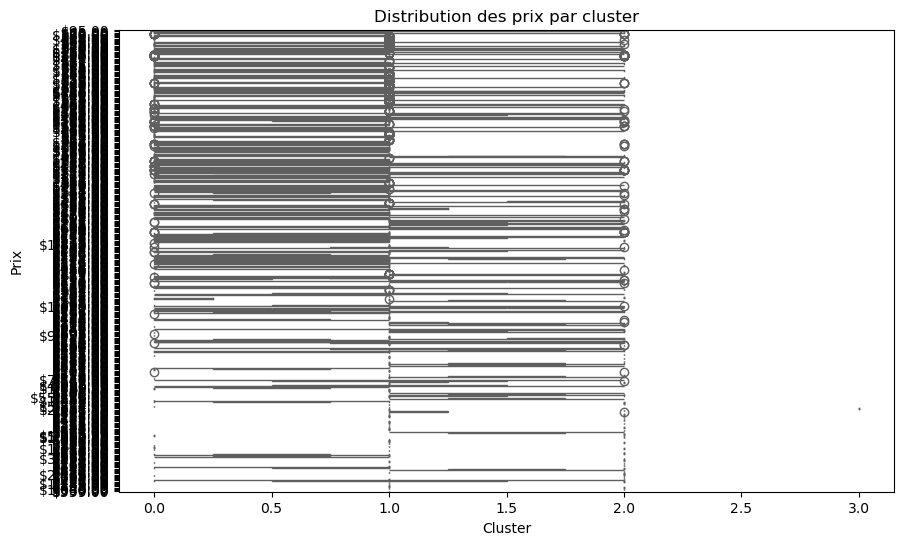

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convertir les données en Pandas pour Seaborn
listings_stats_pd = listings_clustered.select("distance_to_center", "accommodates", "price", "prediction").toPandas()

# Diagramme en boîte des prix par cluster
plt.figure(figsize=(10, 6))
sns.boxplot(data=listings_stats_pd, x="prediction", y="price", palette="Set3")
plt.title("Distribution des prix par cluster")
plt.xlabel("Cluster")
plt.ylabel("Prix")
plt.show()

## Moyennes des clusters

In [24]:
from pyspark.sql.functions import avg

cluster_stats = listings_clustered.groupBy("prediction").agg(
    avg("distance_to_center").alias("avg_distance_to_center"),
    avg("accommodates").alias("avg_accommodates"),
    avg("price").alias("avg_price")
)
cluster_stats.show()

+----------+----------------------+-----------------+---------+
|prediction|avg_distance_to_center| avg_accommodates|avg_price|
+----------+----------------------+-----------------+---------+
|         1|  0.019745594602756874|4.465669445806768|     null|
|         3|   0.00861684455006652|             16.0|     null|
|         2|  0.020027214098097927|8.815950920245399|     null|
|         0|   0.02114881229213048|2.030048076923077|     null|
+----------+----------------------+-----------------+---------+



# Cartographie avec clusters et événements


In [25]:
import pandas as pd
import folium
import math

# Charger les événements
events = pd.read_csv("../events.csv")

# Grouper les événements par lieu
grouped_events = events.groupby(["latitude", "longitude", "address"]).agg({
    "name": "count",  # Nombre d'événements
    "date": lambda x: ", ".join(sorted(x))  # Regrouper les dates
}).reset_index()
grouped_events.rename(columns={"name": "event_count", "date": "dates"}, inplace=True)

# Créer une carte centrée sur Lyon
m = folium.Map(location=[45.764043, 4.835659], zoom_start=12)

# Ajouter des marqueurs avec taille dynamique selon le nombre d'événements
for _, event in grouped_events.iterrows():
    folium.CircleMarker(
        location=[event["latitude"], event["longitude"]],
        radius = 5 + math.log(event["event_count"] + 1) * 3,  # Taille dynamique
        color="blue",
        fill=True,
        fill_color="blue",
        fill_opacity=0.6,
        popup=(
            f"<b>Adresse :</b> {event['address']}<br>"
            f"<b>Nombre d'événements :</b> {event['event_count']}<br>"
            f"<b>Dates :</b> {event['dates']}"
        ),
    ).add_to(m)

# Sauvegarder la carte
m.save("events_frequency_map.html")
print("Carte des événements sauvegardée sous 'events_frequency_map.html'")


Carte des événements sauvegardée sous 'events_frequency_map.html'


1. Optimisation de la structure du code

In [26]:
def load_and_preprocess_listings(spark, file_path, center_lat, center_lon):
    """
    Charge les données de listings et ajoute les colonnes de distance au centre-ville et de localisation.
    """
    listings = spark.read.csv(file_path, header=True, inferSchema=True)
    listings = listings.withColumn(
        "distance_to_center",
        sqrt((col("latitude") - center_lat)**2 + (col("longitude") - center_lon)**2)
    )
    listings = listings.withColumn(
        "location_category",
        when(col("distance_to_center") < 0.05, "Centre-Ville").otherwise("Périphérie")
    )
    return listings

def create_clusters(listings, feature_cols, k=4, seed=42):
    """
    Effectue une clusterisation KMeans sur les listings en utilisant les colonnes spécifiées.
    """
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    listings_features = assembler.transform(listings)
    kmeans = KMeans(k=k, seed=seed)
    model = kmeans.fit(listings_features)
    return model.transform(listings_features)


In [27]:
# Calculer les statistiques des clusters
cluster_summary = listings_clustered.groupBy("prediction").agg(
    avg("price").alias("avg_price"),
    avg("distance_to_center").alias("avg_distance"),
    avg("accommodates").alias("avg_accommodates")
).toPandas()

# Ajouter des clusters avec statistiques dans le popup
for _, row in listings_clustered_pd.iterrows():
    cluster_info = cluster_summary[cluster_summary['prediction'] == int(row['prediction'])]
    avg_price = cluster_info['avg_price'].values[0]
    avg_distance = cluster_info['avg_distance'].values[0]
    avg_accommodates = cluster_info['avg_accommodates'].values[0]

    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=5,
        color=colors[int(row["prediction"]) % len(colors)],
        fill=True,
        fill_color=colors[int(row["prediction"]) % len(colors)],
        fill_opacity=0.7,
        popup=(
            f"<b>Cluster:</b> {int(row['prediction'])}<br>"
            f"<b>Prix moyen:</b> {avg_price:.2f} €<br>"
            f"<b>Distance au centre:</b> {avg_distance:.2f} km<br>"
            f"<b>Capacité moyenne:</b> {avg_accommodates:.1f}"
        ),
    ).add_to(m)


In [28]:
# Ajouter les clusters Airbnb
for _, row in listings_clustered_pd.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=5,
        color=colors[int(row["prediction"]) % len(colors)],
        fill=True,
        fill_color=colors[int(row["prediction"]) % len(colors)],
        fill_opacity=0.7,
        popup=f"Cluster: {int(row['prediction'])}"
    ).add_to(m)

# Ajouter les événements avec des tailles dynamiques
for _, event in grouped_events.iterrows():
    folium.CircleMarker(
        location=[event["latitude"], event["longitude"]],
        radius=5 + math.log(event["event_count"] + 1) * 3,
        color="blue",
        fill=True,
        fill_color="blue",
        fill_opacity=0.6,
        popup=(
            f"<b>Adresse :</b> {event['address']}<br>"
            f"<b>Nombre d'événements :</b> {event['event_count']}<br>"
            f"<b>Dates :</b> {event['dates']}"
        ),
    ).add_to(m)

# Sauvegarder la carte combinée
m.save("combined_map.html")
print("Carte combinée Airbnb et événements sauvegardée sous 'combined_map.html'")


Carte combinée Airbnb et événements sauvegardée sous 'combined_map.html'


In [ ]:
from pyspark.sql.functions import abs, lit

# Charger les événements dans Spark
events_spark = spark.read.csv("../events.csv", header=True, inferSchema=True)

# Retirer les doublons d'événements
events_spark = events_spark.dropDuplicates(["latitude", "longitude"])

# Ajouter une colonne pour la distance à chaque événement
for event in events_spark.collect():
    event_lat = event["latitude"]
    event_lon = event["longitude"]
    event_name = event["name"]

    listings = listings.withColumn(
        f"distance_to_{event_name}",
        sqrt((col("latitude") - lit(event_lat))**2 + (col("longitude") - lit(event_lon))**2)
    )

# Calculer la moyenne des prix en fonction de la distance à un événement
price_vs_event = listings.groupBy(f"distance_to_{event_name}").agg(avg("price").alias("avg_price"))
price_vs_event.show()


In [ ]:
# Convertir les résultats en Pandas pour tracer avec Seaborn
price_vs_event_pd = price_vs_event.toPandas()

# Tracer la relation entre distance et prix
plt.figure(figsize=(10, 6))
sns.lineplot(data=price_vs_event_pd, x=f"distance_to_{event_name}", y="avg_price")
plt.title(f"Prix moyen en fonction de la distance à {event_name}")
plt.xlabel("Distance à l'événement (km)")
plt.ylabel("Prix moyen (€)")
plt.show()